100%|██████████| 9912422/9912422 [00:00<00:00, 112003230.71it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 56631927.92it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27218488.86it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3029182.50it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch [1/10], Loss: 0.0405, Training Accuracy: 93.34%
Epoch [2/10], Loss: 0.1128, Training Accuracy: 97.86%
Epoch [3/10], Loss: 0.0183, Training Accuracy: 98.51%
Epoch [4/10], Loss: 0.0146, Training Accuracy: 98.86%
Epoch [5/10], Loss: 0.0213, Training Accuracy: 99.09%
Epoch [6/10], Loss: 0.0005, Training Accuracy: 99.20%
Epoch [7/10], Loss: 0.0057, Training Accuracy: 99.37%
Epoch [8/10], Loss: 0.0332, Training Accuracy: 99.44%
Epoch [9/10], Loss: 0.0024, Training Accuracy: 99.57%
Epoch [10/10], Loss: 0.0028, Training Accuracy: 99.57%


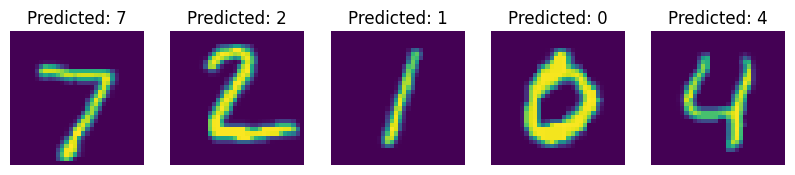

Accuracy of the network on the 10000 test images: 98.4375%


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define the LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Convolutional layers
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.to_linear = None
        self._get_to_linear()

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(self.to_linear, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
        )

    def _get_to_linear(self):
        with torch.no_grad():
            self.to_linear = self.convnet(torch.randn(1, 1, 32, 32)).view(1, -1).size(1)

    def forward(self, x):
        x = self.convnet(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.fc(x)
        return x

# Instantiate the model
lenet5 = LeNet5()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet5.parameters(), lr=0.001)

# Load the MNIST dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32 to match LeNet-5 input
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the dataset with the MNIST mean and std
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Training the model
def train_model(num_epochs):
    lenet5.train()
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(train_loader):
            # Forward pass
            outputs = lenet5(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Calculate training accuracy for the current epoch
        train_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.2f}%')

def imshow(img, ax, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(title)
    ax.axis('off')

def evaluate_model(show_images=True, num_images=5):
    lenet5.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = lenet5(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if show_images:
                # Plot some test images with predicted labels
                fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
                for i in range(num_images):
                    ax = axes[i]
                    imshow(images[i], ax, f'Predicted: {predicted[i]}')
                plt.show()
                break  # Only show one batch of images

        print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

num_epochs = 10
train_model(num_epochs)
evaluate_model()